<a href="https://colab.research.google.com/github/PriyanshuRao-code/AI-Lab-Project/blob/main/notebooks/team_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Don't do anything here. It's just a setup.
import os
import sys

repo_name = "AI-Lab-Project"
repo_url = "https://github.com/PriyanshuRao-code/AI-Lab-Project.git"
repo_path = f"/content/{repo_name}/notebooks"

if os.path.exists(repo_path):
    print("Repository already exists at:", repo_path)
else:
    print("🚀 Cloning the repository...")
    os.system(f"git clone {repo_url}")

os.chdir(repo_path)
sys.path.append(repo_path)

print("Repository is ready to use at:", repo_path)

Repository already exists at: /content/AI-Lab-Project/notebooks
Repository is ready to use at: /content/AI-Lab-Project/notebooks


In [4]:
# Using supporting files (now as .ipynb and later .py)

!pip install import-ipynb
import import_ipynb
from team_24_data_preprocessing import *
from team_24_supervised_learning import *

Repository already exists at: /content/AI-Lab-Project
Repository is ready to use at: /content/AI-Lab-Project


In [5]:
# Start coding from here

In [6]:
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from itertools import product

In [7]:
df = pd.read_csv('24.csv')

In [8]:
df_train_orig, df_temp = train_test_split(df, test_size=0.4, random_state=42)
df_valid_orig, df_test_orig = train_test_split(df_temp, test_size=0.5, random_state=42)
df_train_orig.reset_index(drop=True, inplace=True)
df_valid_orig.reset_index(drop=True, inplace=True)
df_test_orig.reset_index(drop=True, inplace=True)

In [9]:
outlier_methods = [None, "iqr", "zscore"]
encoding_methods = ["label", "feature-extraction"]
scaling_methods = ["minmax", "standard"]
correlation_options = [True, False]
pca_options = [True, False]
select_high_correlat = [True, False]


data_preparation_methods = []

for outlier, encode, scale, correlation, pca, select_high_corr in product(outlier_methods, encoding_methods, scaling_methods, correlation_options, pca_options, select_high_correlat):

    # Skip the unwanted combination
    if pca and encode == "feature-extraction":
      continue

    if pca and select_high_corr:
      continue

    data_preparation_methods.append({
        "outlier": outlier,
        "encode": encode,
        "scale": scale,
        "correlation": correlation,
        "pca": pca,
        "select_corr" : select_high_corr
    })

In [10]:
models = {
    # "Perceptron": train_model_perceptron,
    # "Logistic Regression": train_model_logistic,
    # "KNN": train_model_knn,
    # "Gausian": train_model_gaussian,
    # "SVC": train_model_svc,
    "Random_Forest": train_model_random_forest,
    # "SVC_poly" : train_model_svc_poly,
    # "SVC_rbf" : train_model_svc_rbf,
    # "FCNN": train_model_fcnn
}

In [11]:
def data_preparation(df_train, df_valid, df_test, method):

    if method['outlier'] == "iqr":
        df_train, df_valid, df_test = remove_outliers_iqr(df_train, df_valid, df_test)
    elif method['outlier'] == "zscore":
        df_train, df_valid, df_test = remove_outliers_zscore(df_train, df_valid, df_test)


    if method['scale'] == "minmax":
        df_train, df_valid, df_test = normalize_minmax(df_train, df_valid, df_test)
    elif method['scale'] == "standard":
        df_train, df_valid, df_test = standardize_data(df_train, df_valid, df_test)


    if method['correlation']:
        df_train, df_valid, df_test = remove_highly_correlated(df_train, df_valid, df_test)


    if method['encode'] == "label":
        df_train, df_valid, df_test = label_encode_categorical(df_train, df_valid, df_test)
    elif method['encode'] == "feature-extraction":
        df_train, df_valid, df_test = feature_extraction(df_train, df_valid, df_test)

    if method['pca']:
        df_train, df_valid, df_test = perform_pca(df_train, df_valid, df_test)

    if method['select_corr']:
        df_train, df_valid, df_test = select_high_corr_features(df_train, df_valid, df_test)

    print("One preprocessing")

    return df_train, df_valid, df_test

In [12]:
def evaluate_model(y_true, y_pred, y_score=None):
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1_score": f1_score(y_true, y_pred, zero_division=0)
    }
    if y_score is not None:
        try:
            metrics["roc_auc"] = roc_auc_score(y_true, y_score)
        except:
            metrics["roc_auc"] = None
    else:
        metrics["roc_auc"] = None

    return metrics

In [13]:
results = []

for method in data_preparation_methods:
    df_train, df_valid, df_test = data_preparation(df_train_orig.copy(), df_valid_orig.copy(), df_test_orig.copy(), method)

    for model_name, model_func in models.items():
        model, y_valid, y_test, y_valid_pred, y_test_pred = model_func(df_train, df_valid, df_test)

        # Try to get probabilities or scores for ROC-AUC
        try:
            y_valid_score = model.predict_proba(df_valid.drop("Hazardous", axis=1).values)[:, 1]
            y_test_score = model.predict_proba(df_test.drop("Hazardous", axis=1).values)[:, 1]
        except:
            try:
                y_valid_score = model.decision_function(df_valid.drop("Hazardous", axis=1).values)
                y_test_score = model.decision_function(df_test.drop("Hazardous", axis=1).values)
            except:
                y_valid_score = None
                y_test_score = None


        metrics_valid = evaluate_model(y_valid, y_valid_pred, y_valid_score)
        metrics_test = evaluate_model(y_test, y_test_pred, y_test_score)

        results.append({
            "data_preprocessing_methods": method,
            "model": model_name,
            "valid": metrics_valid,
            "test": metrics_test
        })

# Converting into dataframe
df_results = pd.json_normalize(results, sep='_')


One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One preprocessing
One prepro

In [14]:
df_results

,model,data_preprocessing_methods_outlier,data_preprocessing_methods_encode,data_preprocessing_methods_scale,data_preprocessing_methods_correlation,data_preprocessing_methods_pca,data_preprocessing_methods_select_corr,valid_accuracy,valid_precision,valid_recall,valid_f1_score,valid_roc_auc,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc
0,Random_Forest,None,label,minmax,True,True,False,0.876201,0.711111,0.415584,0.524590,0.881595,0.865672,0.581395,0.357143,0.442478,0.858723
1,Random_Forest,None,label,minmax,True,False,True,0.993597,0.962500,1.000000,0.980892,0.999469,0.995736,0.985714,0.985714,0.985714,0.999678
2,Random_Forest,None,label,minmax,True,False,False,0.994664,0.986928,0.980519,0.983713,0.999743,0.993603,0.992647,0.964286,0.978261,0.998286
3,Random_Forest,None,label,minmax,False,True,False,0.865528,0.689189,0.331169,0.447368,0.868260,0.868870,0.626866,0.300000,0.405797,0.863829
4,Random_Forest,None,label,minmax,False,False,True,0.993597,0.962500,1.000000,0.980892,0.999469,0.995736,0.985714,0.985714,0.985714,0.999678
5,Random_Forest,None,label,minmax,False,False,False,0.995731,0.993421,0.980519,0.986928,0.999631,0.992537,0.978417,0.971429,0.974910,0.994867
6,Random_Forest,None,label,standard,True,True,False,0.875133,0.784615,0.331169,0.465753,0.892144,0.867804,0.653846,0.242857,0.354167,0.866116
7,Random_Forest,None,label,standard,True,False,True,0.993597,0.962500,1.000000,0.980892,0.999465,0.995736,0.985714,0.985714,0.985714,0.999678
8,Random_Forest,None,label,standard,True,False,False,0.994664,0.986928,0.980519,0.983713,0.999743,0.993603,0.992647,0.964286,0.978261,0.998290
9,Random_Forest,None,label,standard,False,True,False,0.852721,0.597561,0.318182,0.415254,0.867530,0.855011,0.527027,0.278571,0.364486,0.838288


In [15]:
df_results.to_csv('random_forest.csv', index=False)

from google.colab import files

files.download('random_forest.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

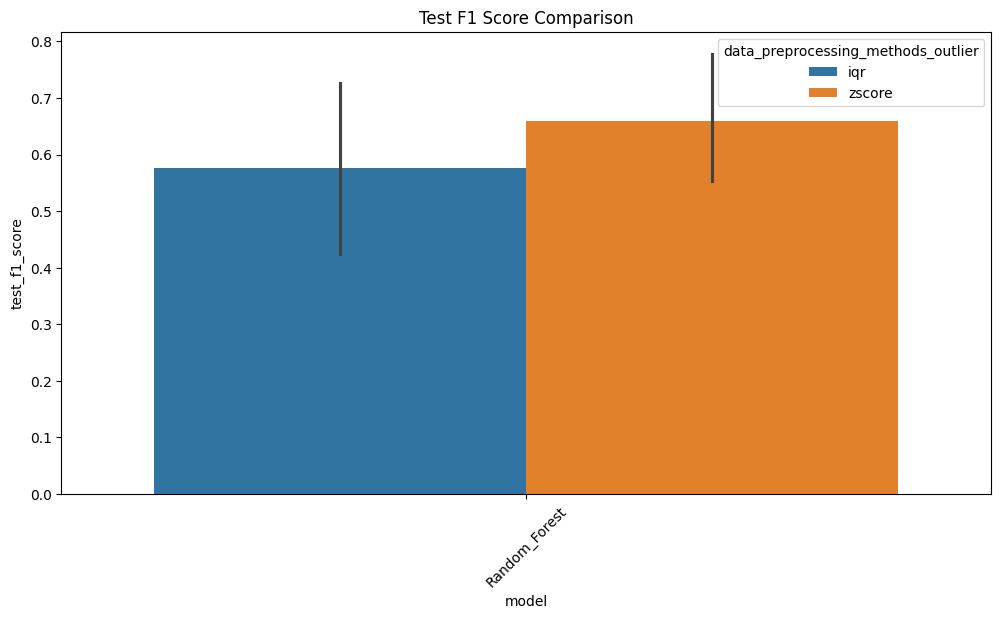

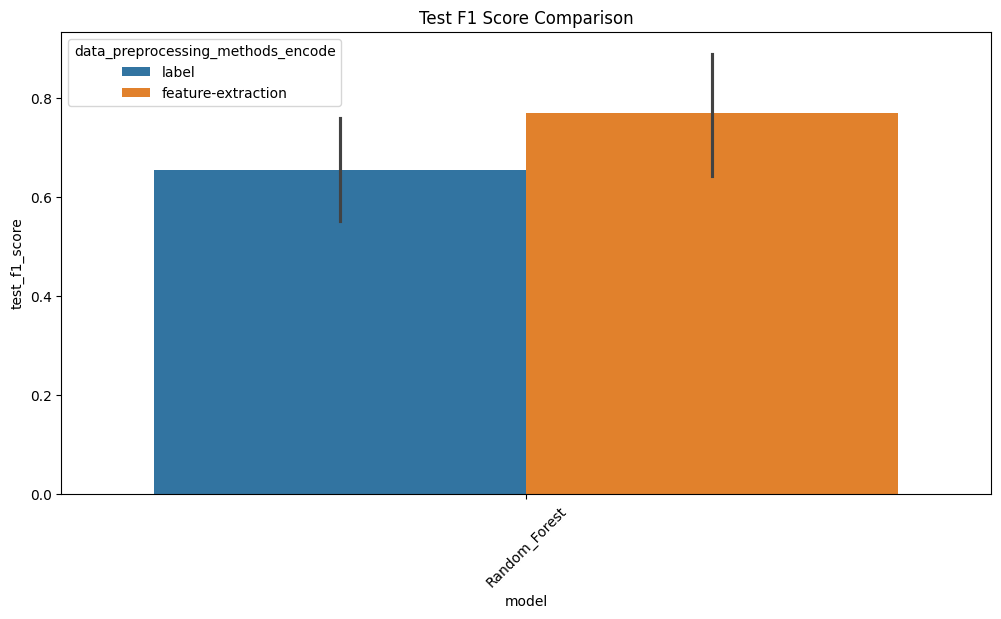

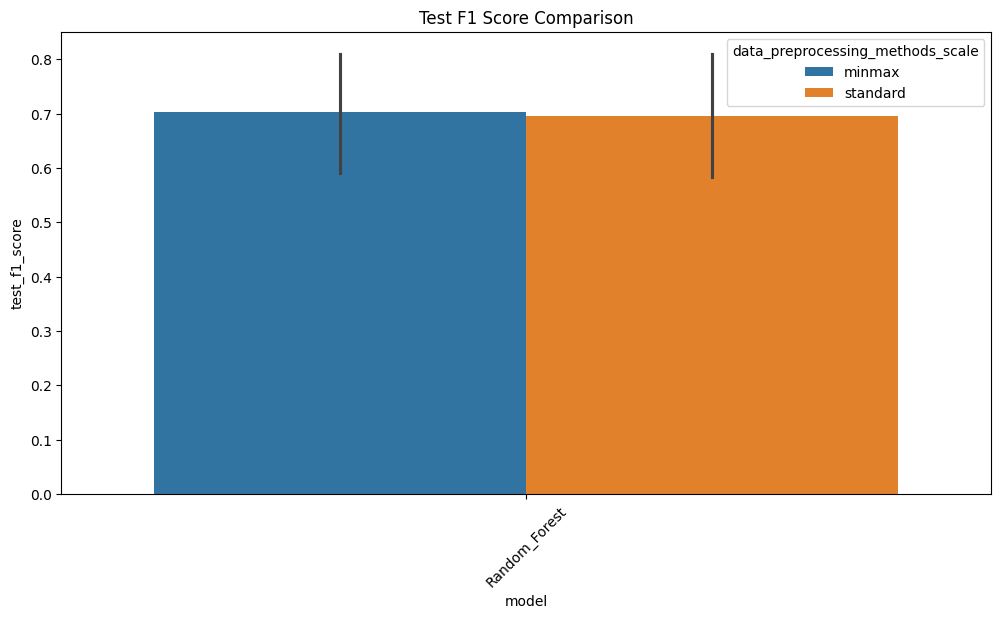

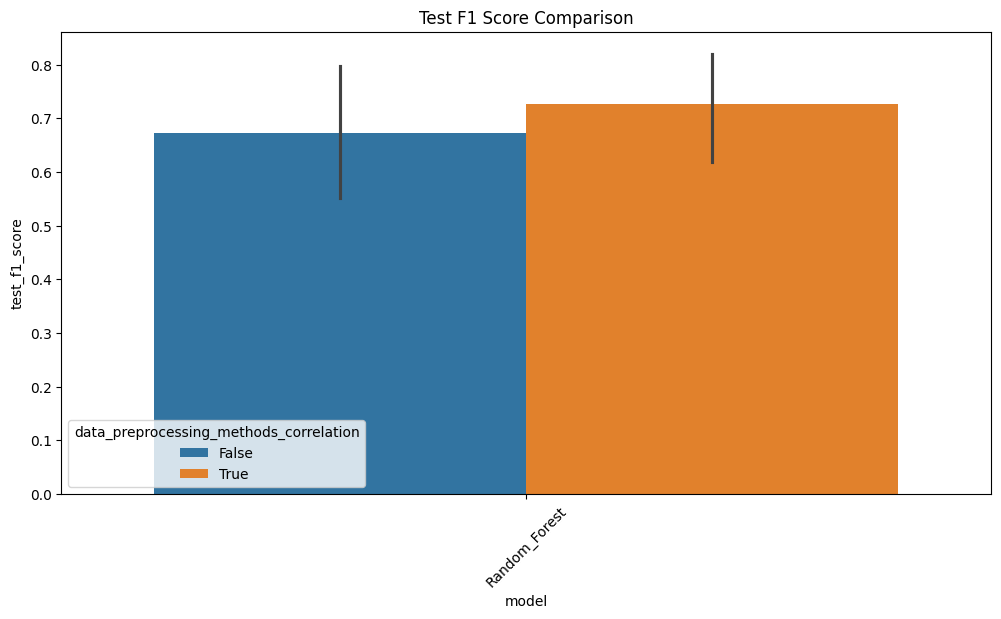

In [16]:
# Bar Plot


plt.figure(figsize=(12,6))
sns.barplot(data=df_results, x='model', y='test_f1_score', hue='data_preprocessing_methods_outlier')
plt.xticks(rotation=45)
plt.title("Test F1 Score Comparison")
plt.show()


plt.figure(figsize=(12,6))
sns.barplot(data=df_results, x='model', y='test_f1_score', hue='data_preprocessing_methods_encode')
plt.xticks(rotation=45)
plt.title("Test F1 Score Comparison")
plt.show()


plt.figure(figsize=(12,6))
sns.barplot(data=df_results, x='model', y='test_f1_score', hue='data_preprocessing_methods_scale')
plt.xticks(rotation=45)
plt.title("Test F1 Score Comparison")
plt.show()


plt.figure(figsize=(12,6))
sns.barplot(data=df_results, x='model', y='test_f1_score', hue='data_preprocessing_methods_correlation')
plt.xticks(rotation=45)
plt.title("Test F1 Score Comparison")
plt.show()

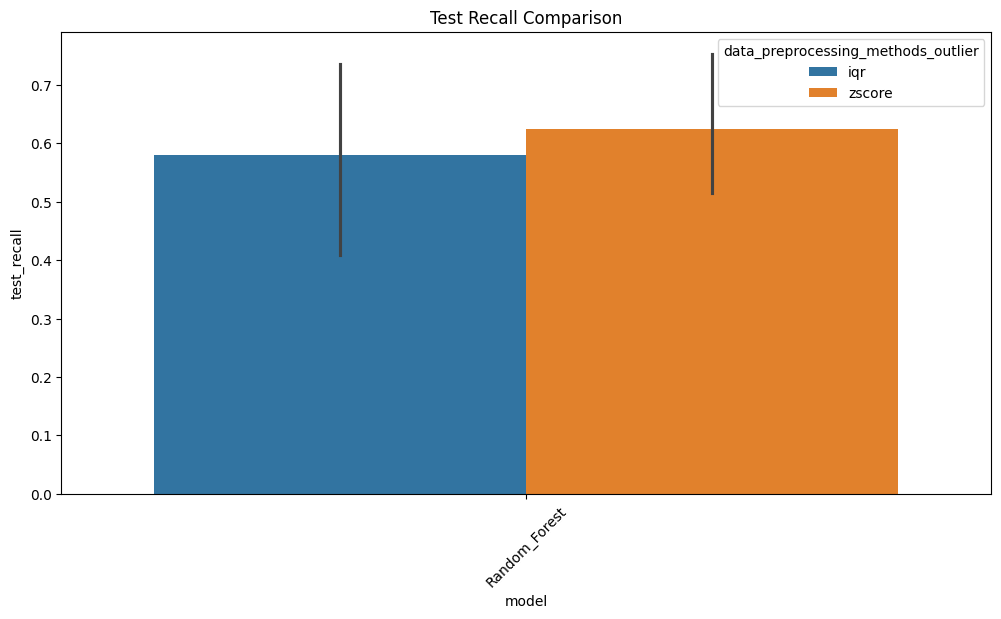

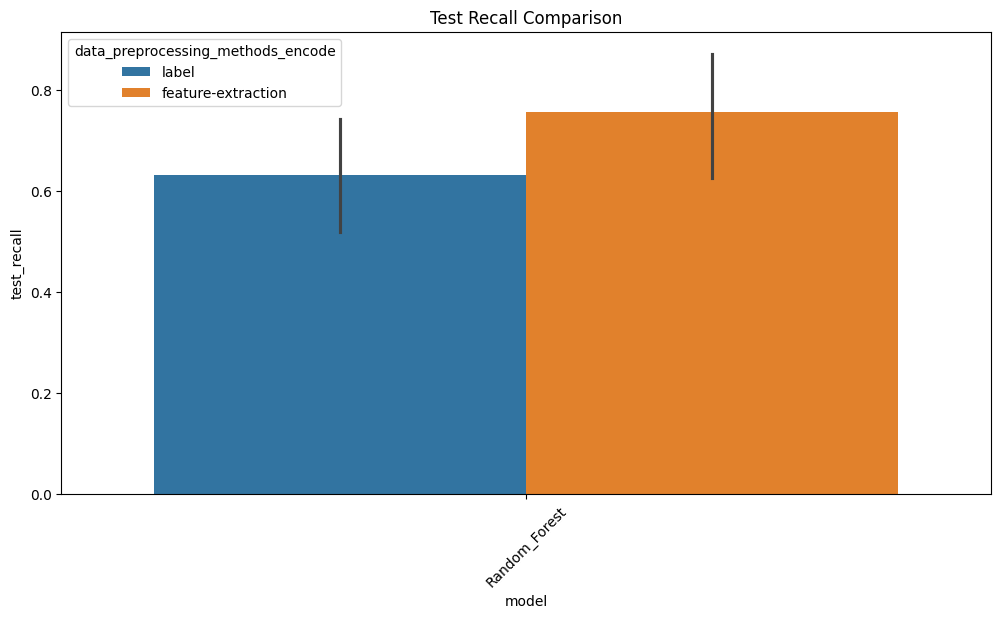

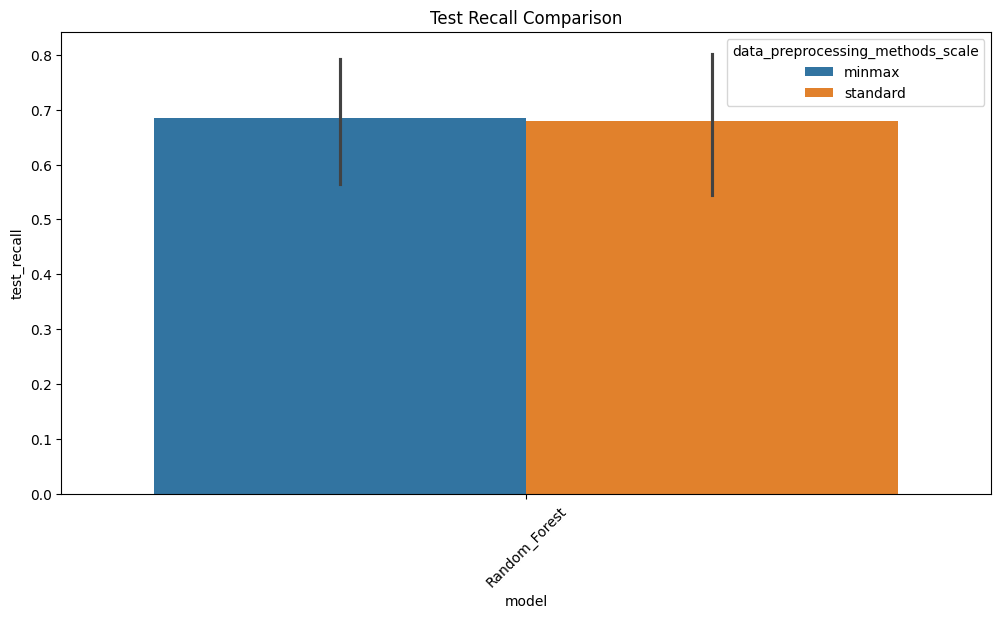

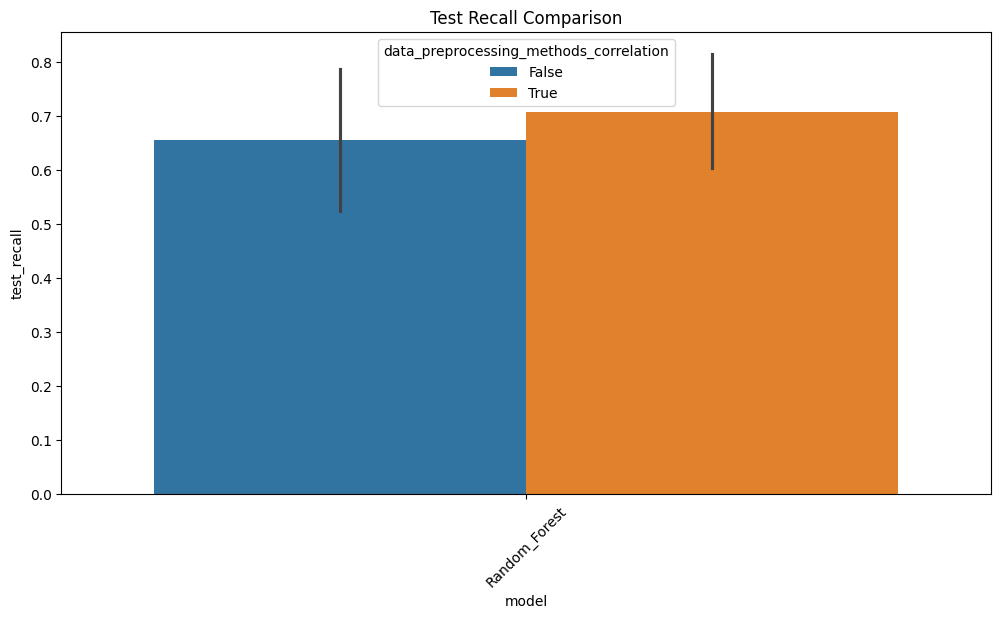

In [17]:
# Bar Plot
plt.figure(figsize=(12,6))
sns.barplot(data=df_results, x='model', y='test_recall', hue='data_preprocessing_methods_outlier')
plt.xticks(rotation=45)
plt.title("Test Recall Comparison")
plt.show()


plt.figure(figsize=(12,6))
sns.barplot(data=df_results, x='model', y='test_recall', hue='data_preprocessing_methods_encode')
plt.xticks(rotation=45)
plt.title("Test Recall Comparison")
plt.show()


plt.figure(figsize=(12,6))
sns.barplot(data=df_results, x='model', y='test_recall', hue='data_preprocessing_methods_scale')
plt.xticks(rotation=45)
plt.title("Test Recall Comparison")
plt.show()



plt.figure(figsize=(12,6))
sns.barplot(data=df_results, x='model', y='test_recall', hue='data_preprocessing_methods_correlation')
plt.xticks(rotation=45)
plt.title("Test Recall Comparison")
plt.show()

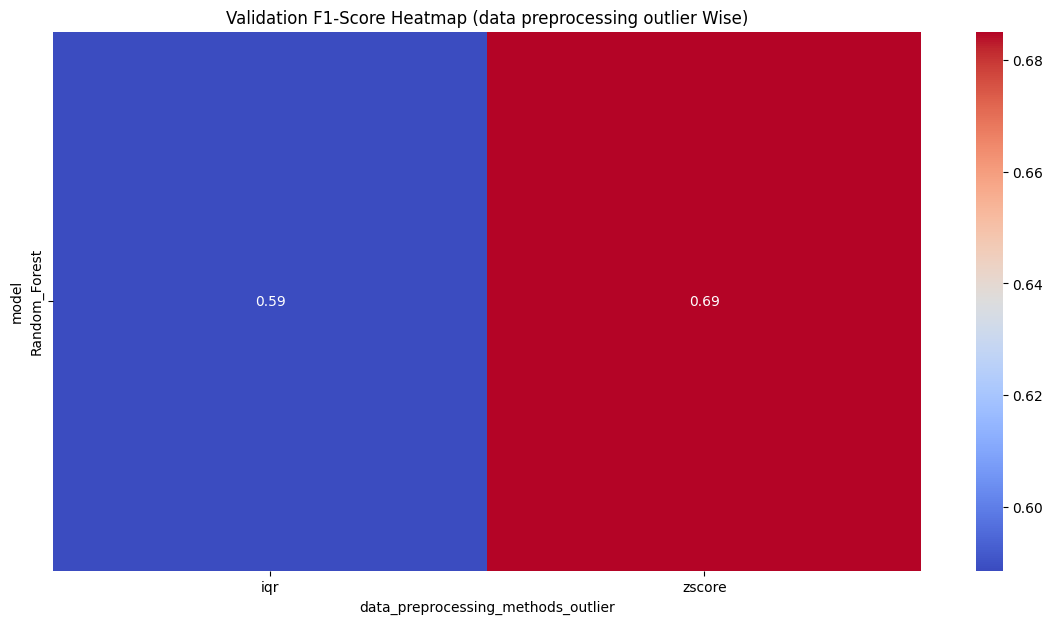

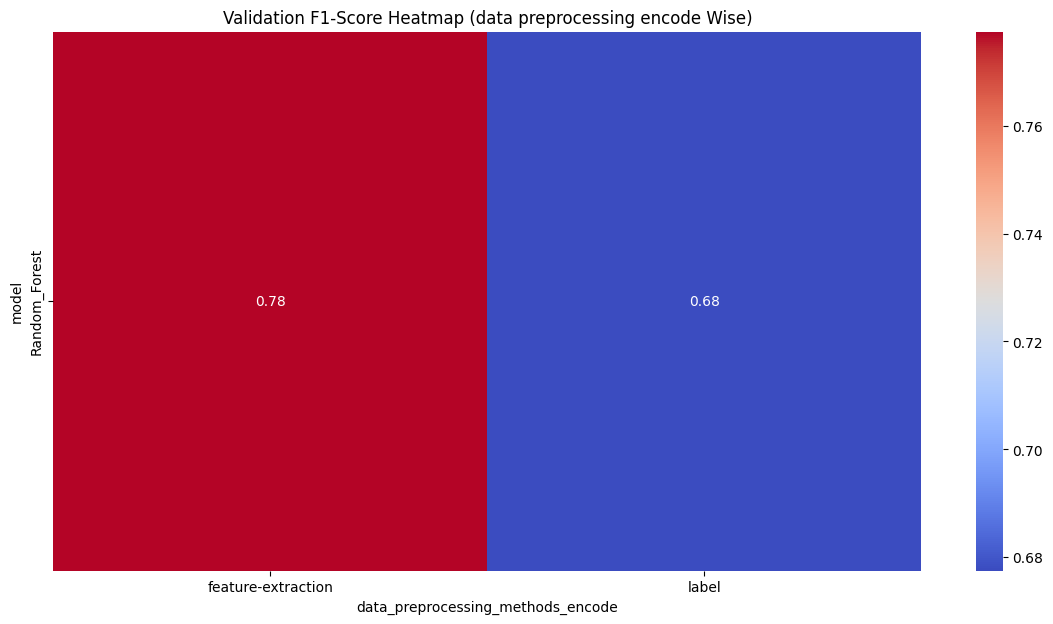

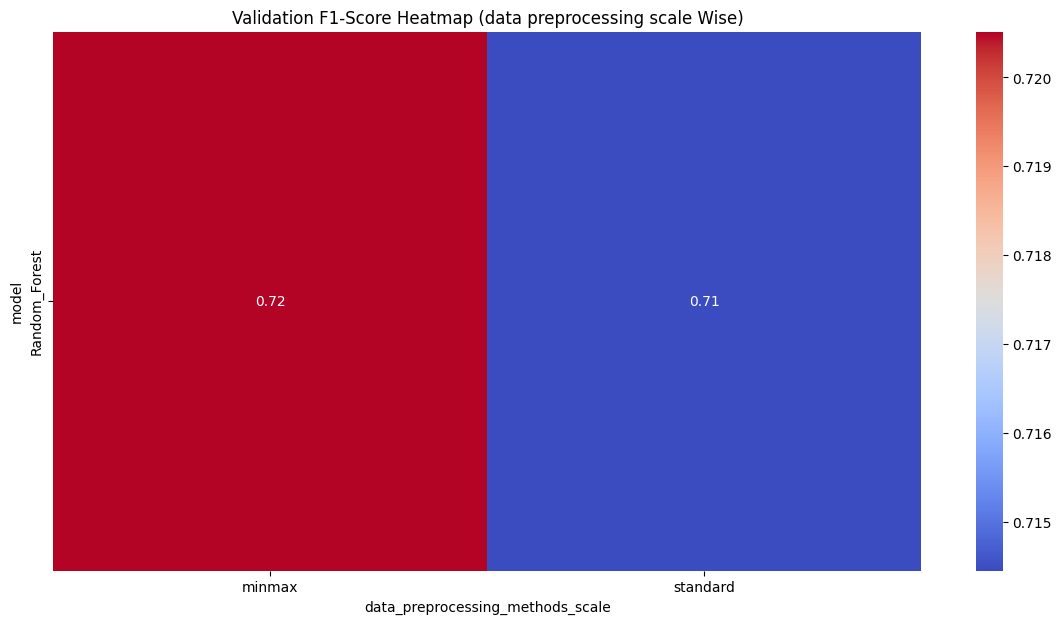

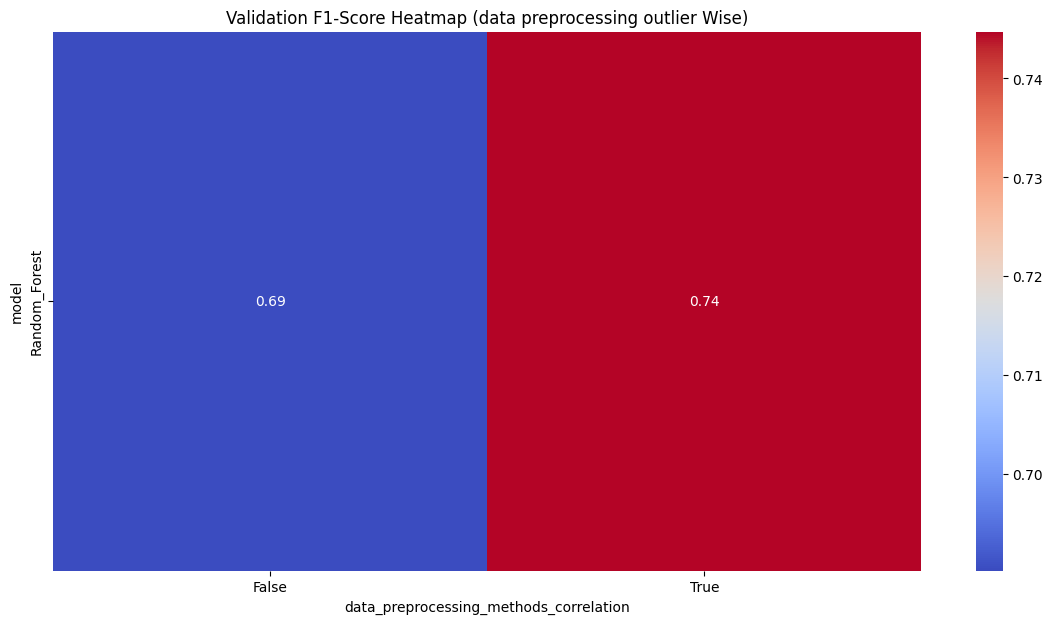

In [18]:
# Heatmap

pivot = df_results.pivot_table(index='model', columns='data_preprocessing_methods_outlier', values='valid_f1_score', aggfunc='mean')
plt.figure(figsize=(14,7))
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title("Validation F1-Score Heatmap (data preprocessing outlier Wise)")
plt.show()


pivot = df_results.pivot_table(index='model', columns='data_preprocessing_methods_encode', values='valid_f1_score', aggfunc='mean')
plt.figure(figsize=(14,7))
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title("Validation F1-Score Heatmap (data preprocessing encode Wise)")
plt.show()

pivot = df_results.pivot_table(index='model', columns='data_preprocessing_methods_scale', values='valid_f1_score', aggfunc='mean')
plt.figure(figsize=(14,7))
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title("Validation F1-Score Heatmap (data preprocessing scale Wise)")
plt.show()

pivot = df_results.pivot_table(index='model', columns='data_preprocessing_methods_correlation', values='valid_f1_score', aggfunc='mean')
plt.figure(figsize=(14,7))
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title("Validation F1-Score Heatmap (data preprocessing outlier Wise)")
plt.show()

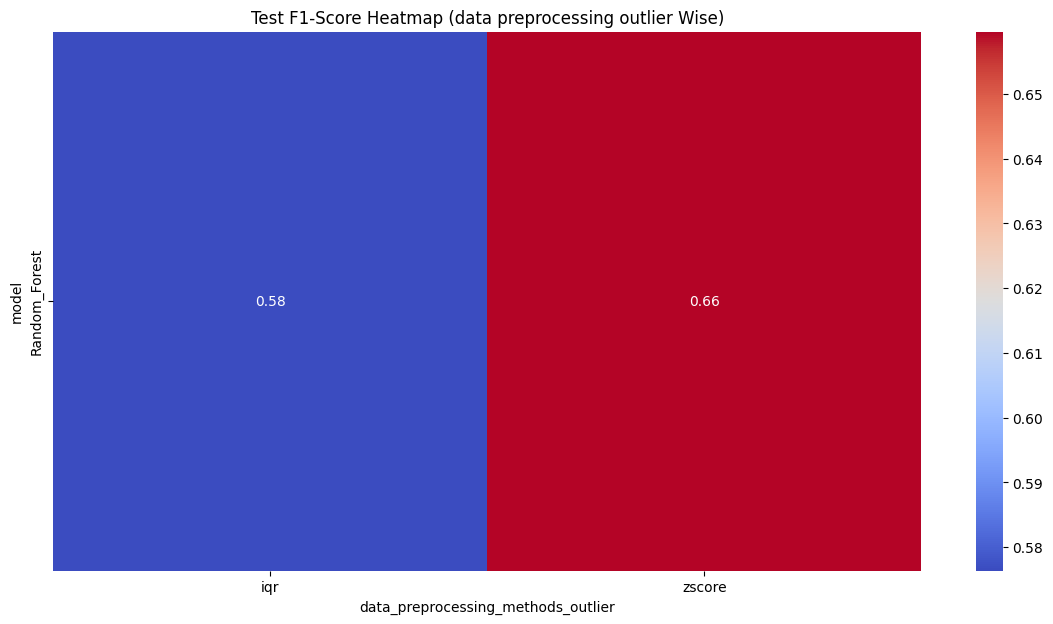

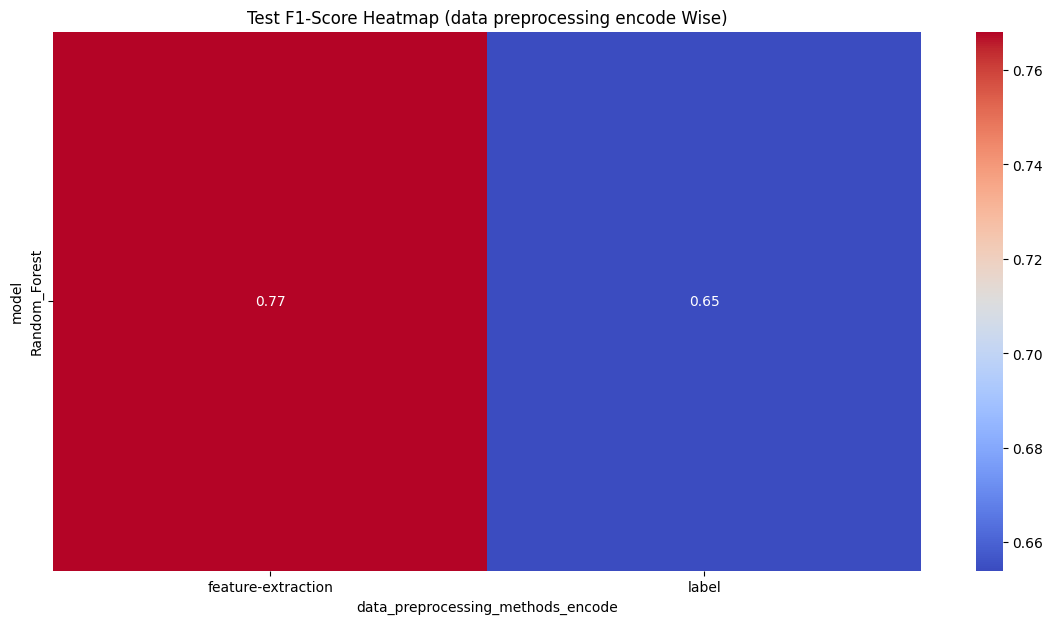

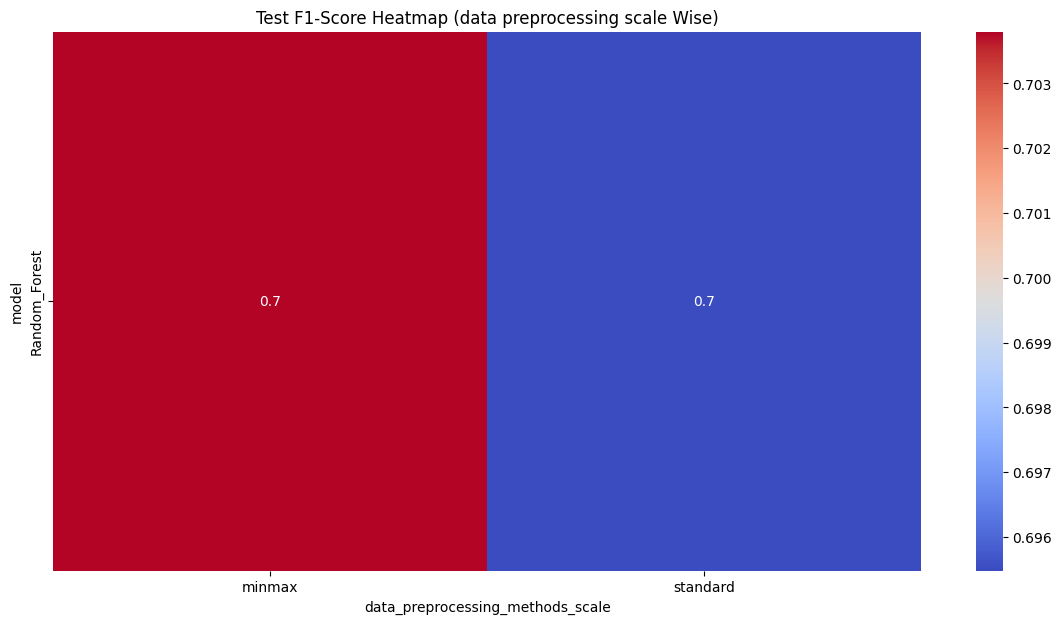

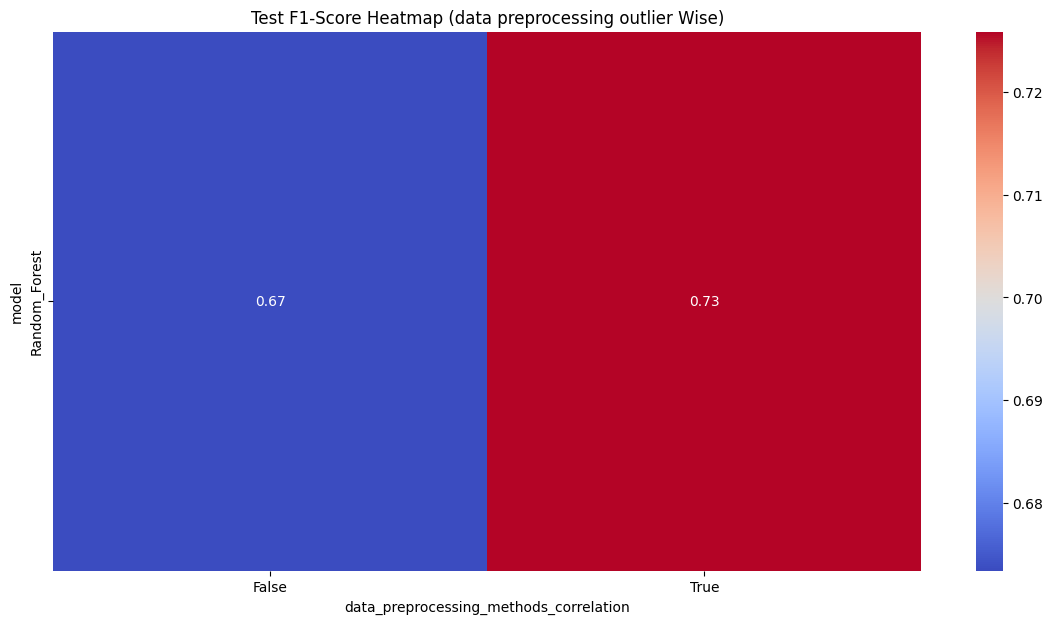

In [19]:
# Heatmap

pivot = df_results.pivot_table(index='model', columns='data_preprocessing_methods_outlier', values='test_f1_score', aggfunc='mean')
plt.figure(figsize=(14,7))
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title("Test F1-Score Heatmap (data preprocessing outlier Wise)")
plt.show()


pivot = df_results.pivot_table(index='model', columns='data_preprocessing_methods_encode', values='test_f1_score', aggfunc='mean')
plt.figure(figsize=(14,7))
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title("Test F1-Score Heatmap (data preprocessing encode Wise)")
plt.show()

pivot = df_results.pivot_table(index='model', columns='data_preprocessing_methods_scale', values='test_f1_score', aggfunc='mean')
plt.figure(figsize=(14,7))
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title("Test F1-Score Heatmap (data preprocessing scale Wise)")
plt.show()

pivot = df_results.pivot_table(index='model', columns='data_preprocessing_methods_correlation', values='test_f1_score', aggfunc='mean')
plt.figure(figsize=(14,7))
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title("Test F1-Score Heatmap (data preprocessing outlier Wise)")
plt.show()

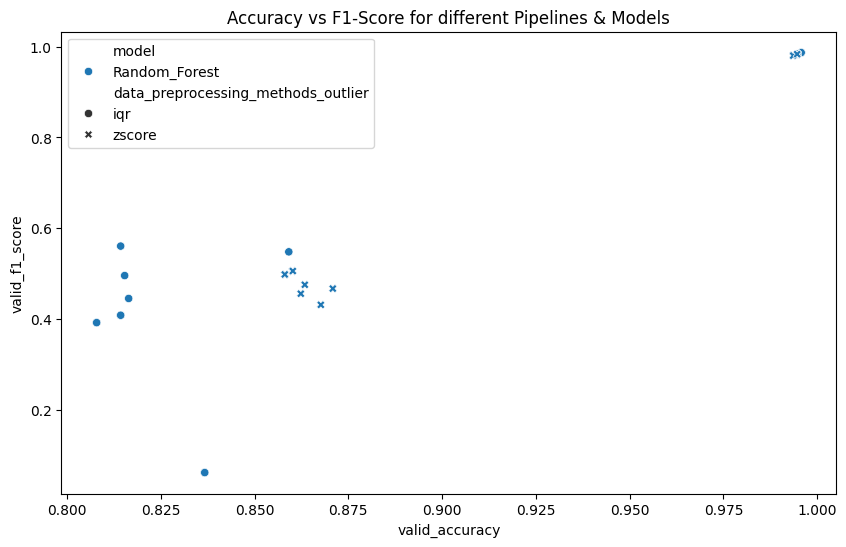

In [20]:
# Scatter Plot


plt.figure(figsize=(10,6))
sns.scatterplot(data=df_results, x='valid_accuracy', y='valid_f1_score', hue='model', style='data_preprocessing_methods_outlier')
plt.title("Accuracy vs F1-Score for different Pipelines & Models")
plt.show()